In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# import sklearn
# from numba import jit

# visual_drift_coef = 1.2
# visual_drift_min = 0.8
# memory_drift_coef = 0.7
# memory_drift_adaptive_coef = 0
# visual_drift_adaptive_coef = 0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from numba import jit

visual_drift_coef = 1
visual_drift_min = 0.8
memory_drift_coef = 0.7
memory_drift_adaptive_coef = 0
visual_drift_adaptive_coef = 0

I can add visual delay later to account for bigger RT at the beginning

Important: Check for memory drift adding after a press or after the visual delay for the next press

In [3]:
%load_ext line_profiler

In [4]:
def calc_visual_drifts(seq, seq_length):
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result



In [5]:
def calc_memory_drifts(specific_seq, seq_length):
    seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result

In [6]:
seq = '13524232514111'
specific_seq = '13524232514111'
random_seq = '45341323141322'
specific_seq_changed = '13524223141322'
specific_seq_changed_one_digit = '13524212514111'


seq_length = len(seq)

window_sizes = [1,2,3,4,11]

visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

# drifts = np.array([1,1,1,1,2]).reshape(5, 1)
# drifts = np.repeat(drifts, seq_length , axis = 1)

visual_delay = 90
motor_delay = 50

diffusion = 3
threshold = 300
alpha = 0.999
beta = 0.001


# param = [0.80456878, 0.36385731, 0.75921864, 0.36382248, 0.17006857,
#        0.72666298, 0.36340774, 0.16293408, 0.07705195]


# param = [0.81403939, 0.39269762, 0.78576587, 0.39263559, 0.1590846 ,
#        0.78171855, 0.39182347, 0.13888817, 0.05866263]


# param = [0.80546286, 0.34406671, 0.77078511, 0.34047097, 0.17400204,
#        0.76927114, 0.33807873, 0.16315422, 0.08028436]


# param = [0.75295921, 0.50182646, 0.73406735, 0.45987093, 0.34447993,
#         0.69723121, 0.41742494, 0.2493258 , 0.24174475]


param = [0.782587,  0.4290474,  0.7447472,  0.4274116,  0.31541915]

In [7]:
# seq = '13524232514'
# specific_seq = '13524232514'
# random_seq = '45341323141'
# specific_seq_changed = '13524313333'
# specific_seq_changed_one_digit = '13524212514'


# seq_length = len(seq)

# window_sizes = [1,2,3,4,11]

# visual_drifts = calc_visual_drifts(seq, seq_length)
# memory_drifts = calc_memory_drifts(specific_seq, seq_length)

# # drifts = np.array([1,1,1,1,2]).reshape(5, 1)
# # drifts = np.repeat(drifts, seq_length , axis = 1)

# visual_delay = 150

# diffusion = 2
# threshold = 300
# alpha = 0.999
# beta = 0.001


In [8]:
visual_drifts

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [9]:
memory_drifts

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [10]:
exp_normalized_planning_jit(capacity=4, param = 3)

NameError: name 'exp_normalized_planning_jit' is not defined

In [11]:
exp_normalized_planning_jit(capacity=4, param = np.array([5,0.5, 0.1, -0.2]))

NameError: name 'exp_normalized_planning_jit' is not defined

In [12]:
# @jit(nopython=True)
# def get_planning_coefs(strategy, capacity, param):
#     if strategy == 0:
#         return exp_normalized_planning_jit(capacity, param)
#     elif strategy == 1:
#         return inv_normalized_planning_jit(capacity)
#     else:
#         raise ValueError("Unknown strategy")

# @jit(nopython=True)
# def exp_normalized_planning_jit(capacity, param):
#     if capacity >= 4:
#         capacity = 4
    
#     theta = np.arange(1, capacity + 1, dtype=np.float64)
#     exp_base = np.log(capacity) / np.log(param[0])

#     # exp_base = np.log(param[0]) / np.log(4 - capacity + 1 + param[0])
#     # exp_base = np.log(capacity - 1 + param[0]) / np.log(param[0])
#     if capacity == 0 or capacity == 1:
#         return theta
#     else:  
#         theta = np.exp(theta * np.log(exp_base))
#     # exp_base = np.exp(- np.log(param) * capacity)
    
#     if capacity == 2:
#         theta *= param[1]
#         theta += param[2]
#     elif capacity == 3:
#         theta *= param[3]
#         theta += param[4]
#     elif capacity >= 4: 
#         # print(theta)
#         theta *= param[5]
#         # print(theta)
#         theta += param[6]
#         # print(theta)

#     return theta
    

# @jit(nopython=True)
# def inv_normalized_planning_jit(capacity):
#     x = np.arange(capacity)
#     theta = 1 / (x + 1)
#     # theta /= np.sum(theta)
#     return theta

In [13]:
exp_normalized_planning_jit(3, [ 5.0,  0.49877208,  1.22940906,  0.09617734,  0.88317181,
       -0.22210219,  0.86935384])

NameError: name 'exp_normalized_planning_jit' is not defined

In [14]:
@jit(nopython=True)
def get_planning_coefs(strategy, capacity, param):
    if strategy == 0:
        return exp_normalized_planning_jit(capacity, param)
    elif strategy == 1:
        return inv_normalized_planning_jit(capacity)
    else:
        raise ValueError("Unknown strategy")

# @jit(nopython=True)
# def exp_normalized_planning_jit(capacity, param):
#     theta = np.zeros(capacity)
    
#     if capacity == 0:
#         return theta
#     if capacity == 1:
#         theta[0] = 1
#     elif capacity == 2:
#         theta[0] = param[0]
#         theta[1] = param[1]
#     elif capacity == 3:
#         theta[0] = param[2]
#         theta[1] = param[3]
#         theta[2] = param[4]
#     elif capacity >= 4: 
#         theta[0] = param[5]
#         theta[1] = param[6]
#         theta[2] = param[7]
#         theta[3] = param[8]

#     return theta

@jit(nopython=True)
def exp_normalized_planning_jit(capacity, param):
    theta = np.zeros(capacity)
    
    if capacity == 0:
        return theta
    if capacity == 1:
        theta[0] = 1
    elif capacity == 2:
        theta[0] = param[0]
        theta[1] = param[1]
    elif capacity >= 3:
        theta[0] = param[2]
        theta[1] = param[3]
        theta[2] = param[4]

    return theta
    

@jit(nopython=True)
def inv_normalized_planning_jit(capacity):
    x = np.arange(capacity)
    theta = 1 / (x + 1)
    # theta /= np.sum(theta)
    return theta

In [15]:
# @jit(nopython=True)
# def exp_normalized_planning_jit(capacity, param):
#     x = np.arange(1, capacity + 1)
#     if capacity == 0:
#         theta = np.exp(-x * np.log(param))
#     if capacity == 1:
#         theta = np.exp(-x * np.log(param))
#     if capacity == 2:
#         theta = np.exp(-x * np.log(2.3))
    
#     if capacity == 3:
#         theta = np.exp(-x * np.log(2.4))

#     if capacity >= 4: 
#         theta = np.exp(-x * np.log(2.45))

#     # theta /= np.sum(theta)
    
#     return theta * 3

In [16]:
# @jit(nopython=True)
# def exp_normalized_planning_jit(capacity, param):
#     x = np.arange(1, capacity + 1)
#     if capacity == 0:
#         theta = np.exp(-x * np.log(param))
#     if capacity == 1:
#         theta = np.exp(-x * np.log(param))
#     if capacity == 2:
#         theta = np.exp(-x * np.log(1.9))
    
#     if capacity == 3:
#         theta = np.exp(-x * np.log(2.05))

#     if capacity >= 4: 
#         theta = np.exp(-x * np.log(2.1))

#     # theta /= np.sum(theta)
    
#     return theta * 1.5

In [17]:
exp_normalized_planning_jit(capacity = 2, param = 1.5)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(float64, Literal[int](0))
 
There are 22 candidate implementations:
      - Of which 22 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(float64, int64)':
       No match.

During: typing of intrinsic-call at /var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_11220/4176138596.py (42)
During: typing of static-get-item at /var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_11220/4176138596.py (42)

File "../../../../var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_11220/4176138596.py", line 42:
<source missing, REPL/exec in use?>


In [18]:
exp_normalized_planning_jit(capacity = 3, param = 1.5)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(float64, Literal[int](0))
 
There are 22 candidate implementations:
      - Of which 22 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(float64, int64)':
       No match.

During: typing of intrinsic-call at /var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_11220/4176138596.py (42)
During: typing of static-get-item at /var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_11220/4176138596.py (42)

File "../../../../var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_11220/4176138596.py", line 42:
<source missing, REPL/exec in use?>


In [19]:
exp_normalized_planning_jit(capacity = 4, param = 1.5)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(float64, Literal[int](0))
 
There are 22 candidate implementations:
      - Of which 22 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(float64, int64)':
       No match.

During: typing of intrinsic-call at /var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_11220/4176138596.py (42)
During: typing of static-get-item at /var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_11220/4176138596.py (42)

File "../../../../var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_11220/4176138596.py", line 42:
<source missing, REPL/exec in use?>


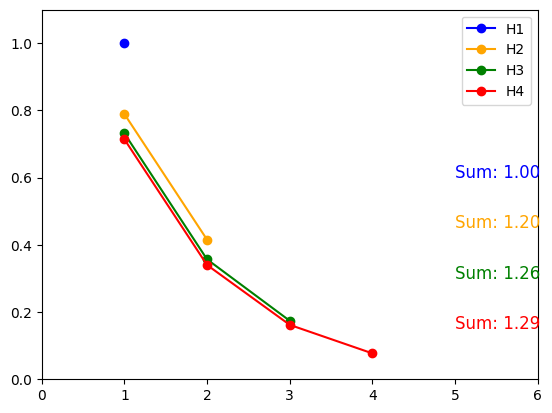

In [20]:
import matplotlib.pyplot as plt

# Original data points
blue_points = [1]
orange_points = [0.78947368, 0.41551247]
green_points = [0.73170732, 0.3569304 , 0.17411239]
red_points = [0.71428571, 0.34013605, 0.16196955, 0.07712836]

# Calculate the sums
blue_sum = sum(blue_points)
orange_sum = sum(orange_points)
green_sum = sum(green_points)
red_sum = sum(red_points)

# Original plot
plt.plot([1], blue_points, 'o-', color='blue', label = 'H1')
plt.plot([1, 2], orange_points, 'o-', color='orange', label = 'H2')
plt.plot([1, 2, 3], green_points, 'o-', color='green', label = 'H3')
plt.plot([1, 2, 3, 4], red_points, 'o-', color='red', label = 'H4')

# Adding the sums on the side
plt.text(5, 0.6, f'Sum: {blue_sum:.2f}', fontsize=12, color='blue')
plt.text(5, 0.45, f'Sum: {orange_sum:.2f}', fontsize=12, color='orange')
plt.text(5, 0.3, f'Sum: {green_sum:.2f}', fontsize=12, color='green')
plt.text(5, 0.15, f'Sum: {red_sum:.2f}', fontsize=12, color='red')

# Adjust plot limits to make room for text
plt.xlim(0, 6)
plt.ylim(0, 1.1)

plt.legend()
# Show plot
plt.show()


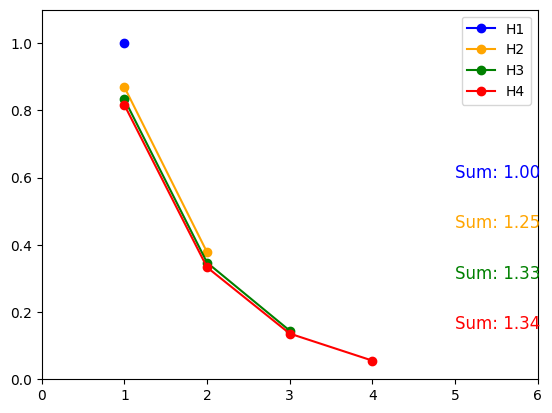

In [21]:
import matplotlib.pyplot as plt

# Original data points
blue_points = [1]
orange_points = [0.86956522, 0.37807183]
green_points = [0.83333333, 0.34722222, 0.14467593]
red_points = [0.81632653, 0.3331945, 0.13599776, 0.05550929]

# Calculate the sums
blue_sum = sum(blue_points)
orange_sum = sum(orange_points)
green_sum = sum(green_points)
red_sum = sum(red_points)

# Original plot
plt.plot([1], blue_points, 'o-', color='blue', label = 'H1')
plt.plot([1, 2], orange_points, 'o-', color='orange', label = 'H2')
plt.plot([1, 2, 3], green_points, 'o-', color='green', label = 'H3')
plt.plot([1, 2, 3, 4], red_points, 'o-', color='red', label = 'H4')

# Adding the sums on the side
plt.text(5, 0.6, f'Sum: {blue_sum:.2f}', fontsize=12, color='blue')
plt.text(5, 0.45, f'Sum: {orange_sum:.2f}', fontsize=12, color='orange')
plt.text(5, 0.3, f'Sum: {green_sum:.2f}', fontsize=12, color='green')
plt.text(5, 0.15, f'Sum: {red_sum:.2f}', fontsize=12, color='red')

# Adjust plot limits to make room for text
plt.xlim(0, 6)
plt.ylim(0, 1.1)

plt.legend()
# Show plot
plt.show()


In [22]:
def exp_normalized_planning(capacity=3, param = 3):
    """
    Exponential decay function for planning

    args: 
        capacity (int): capacity of planning
        param (list/np.array): rate
    """
    x = np.arange(capacity)
    theta = np.exp(-x * np.log(param))
    # theta /= sum(theta)

    return theta


def inv_normalized_planning(capacity=3):
    x = np.arange(capacity)
    theta = 1/(x+1)
    # theta /= sum(theta)

    return theta

In [23]:
def check_evidence_to_seq(evidence, seq):
    for press in range(len(seq)):
        if ~(np.argmax(evidence[:, press]) + 1 == int(seq[press])):
            return False
    return True

In [24]:
def calculate_IPI_from_press_time(press_times):

   return np.array([press_times[0]] + [press_times[i] - press_times[i-1] for i in range(1, len(press_times))])

# Important: 
check what happens if memory only applies when the current_plan is equal to current_execed

In [25]:
@jit(nopython=True)
def simulate_ddm(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt, max_time, 
                 seq_length, window_size, planning_capacity, planning_param, planning_strategy, visual_delay, motor_delay, alpha, beta, memory_drift_coef):
    evidence = np.zeros((5, seq_length))
    time = 0
    visual_delay_queue = np.zeros(min(window_size, seq_length), dtype=float)
    motor_delay_queue = np.zeros(0, dtype=float)
    current_press_planned = 0
    current_press_execed = 0

    current_memory_coef = memory_drift_coef
    current_visual_coef = visual_drift_coef

    effective_planning_capacity = 0
    visible_window_size = 0

    planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    sqrt_dt = np.sqrt(dt)
    drifts_visual_dt = visual_drifts * dt
    drifts_memory_dt = memory_drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, seq_length, total_steps)
    random_terms_memory = np.random.rand(5, total_steps)

    t_index = 0

    press_times = np.full(seq_length, np.nan)
    A = np.eye(5) * alpha - np.full((5,5), beta) + np.eye(5) * beta


    while time < max_time - dt:
        time += dt
        visual_delay_queue += dt
        if len(motor_delay_queue) > 0:
            motor_delay_queue[0] += dt
        t_index += 1

        evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
        evidence[:, current_press_planned:] += diffusion_term * random_terms[:, current_press_planned:, t_index]

        for press in range(current_press_planned, min(current_press_planned + visible_window_size, seq_length, current_press_planned + effective_planning_capacity)):
            # evidence[:, press] += planning_coefs[press - current_press_planned] * drifts_visual_dt[:, press] * current_visual_coef + diffusion_term * random_terms[:, t_index]
            evidence[:, press] += planning_coefs[press - current_press_planned] * drifts_visual_dt[:, press] * current_visual_coef
            
            if press == current_press_planned:
                # if seq[current_press_planned] == specific_seq[current_press_planned]:
                #     # evidence[:, current_press_planned] += drifts_memory_dt[:, current_press_planned] + diffusion_term / 2 * random_terms_memory[:, t_index]
                #     evidence[:, current_press_planned] += drifts_memory_dt[:, current_press_planned] * current_memory_coef
                evidence[:, current_press_planned] += drifts_memory_dt[:, current_press_planned] * current_memory_coef

        evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])
            


        if (evidence[:, current_press_planned:min(current_press_planned + visible_window_size, seq_length, current_press_planned + effective_planning_capacity)] >= threshold).any():
            visible_window_size -= 1
            # press_times[current_press_planned] = time
            # if seq[current_press_planned] == specific_seq[current_press_planned]:
            #     current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef
            #     current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
            # else:
            #     current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef
            #     current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef
                
            current_press_planned += 1
            # visual_delay_queue = np.append(visual_delay_queue, 0)
            motor_delay_queue = np.append(motor_delay_queue, 0)
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


        if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= motor_delay:
            motor_delay_queue = motor_delay_queue[1:]
            visual_delay_queue = np.append(visual_delay_queue, 0)
            press_times[current_press_execed] = time

            if seq[current_press_execed] == specific_seq[current_press_execed]:
                current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef
                current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
            else:
                current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef
                current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef

            current_press_execed += 1
            
            if current_press_execed == seq_length:
                break   

        visual_delay_passed_mask = (visual_delay_queue >= visual_delay)
        pass_count = sum(visual_delay_passed_mask)
        if pass_count > 0:
            visible_window_size += pass_count
            visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    return press_times, evidence

In [26]:
class DriftDiffusionModel_Optimzied:
    def __init__(self, seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt = 1, max_time = 10000,  #todo: when changing dt, the round(time, 2) should be changed according to the precision of dt
                 seq_length = 11, window_size = 2, planning_capacity = 3, planning_param = 3,  
                 planning_strategy = 0, visual_delay = visual_delay, motor_delay = motor_delay,  alpha = 0.995, beta = 0.001, memory_drift_coef = 0.7): #todo: consider having different diffusions for different fingers (e.g. should we have different one when interference happens?)
        """
        Initialize the Drift-Diffusion Model.

        Parameters:
        drifts (list of float): List of drift rates for each process.
        diffusion (float): Diffusion coefficient (assumed to be the same for all processes).
        threshold (float): Decision threshold.
        dt (float): Time step for the discrete-time simulation.
        max_time (float): Maximum simulation time to prevent infinite loops.
        """
        self.seq_length = seq_length
        self.presses = [None for _ in range(seq_length)]
        self.window_size = window_size
        assert visual_drifts.shape == (5,seq_length), "There must be exactly 5 drift rates."
        self.visual_drifts = visual_drifts 
        self.memory_drifts = memory_drifts
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.planning_strategy = planning_strategy
        self.planning_capacity = planning_capacity
        self.planning_param = planning_param
        self.press_times = [None for _ in range(seq_length)]
        self.visual_delay = visual_delay
        self.motor_delay = motor_delay
        self.seq = seq
        self.specific_seq = specific_seq
        self.alpha = alpha
        self.beta = beta

        self.memory_drift_coef = memory_drift_coef
    

    def simulate(self):
        press_times, evidence = simulate_ddm(self.seq, self.specific_seq, self.visual_drifts, self.memory_drifts,
                                              self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, 
                                              self.window_size, self.planning_capacity, self.planning_param, 
                                              self.planning_strategy, self.visual_delay, self.motor_delay, self.alpha, self.beta, self.memory_drift_coef)
        self.press_times = press_times
        return calculate_IPI_from_press_time(self.press_times), evidence
    


    def plot_IPIs(self):
        plt.plot(range(self.seq_length), calculate_IPI_from_press_time(self.press_times))
        plt.show()
                
    
    
    def plot_simulations(self):
        """
        Plot the evidence accumulation for the specified number of simulations.

        Parameters:
        num_simulations (int): Number of simulations to plot.
        """ 
        
        fig, axs = plt.subplots(self.seq_length, figsize=(15,20))
        evidence = np.zeros((5, self.seq_length))
        evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
        time = 0
        t_index = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length), dtype=float)
        motor_delay_queue = np.array([], dtype=float)
        current_press_planned = 0
        current_press_execed = 0

        current_memory_coef = memory_drift_coef
        current_visual_coef = visual_drift_coef

        effective_planning_capacity = 0
        planning_coefs = get_planning_coefs(strategy= self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
        visible_window_size = 0

        press_times = np.full(seq_length, np.nan)
        A = np.eye(5) * self.alpha - np.full((5,5), beta) + np.eye(5) * beta

        total_steps = int(self.max_time / self.dt)

        random_terms = np.random.randn(5, seq_length ,total_steps)
        # visual_delay_passed = False

        while time < self.max_time - self.dt:
            time += self.dt
            t_index += 1
            visual_delay_queue += self.dt
            if len(motor_delay_queue) > 0:
                motor_delay_queue[0] += self.dt
            # current_press_time += self.dt


            evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
            evidence[:, current_press_planned:] += self.diffusion * np.sqrt(self.dt) * random_terms[:, current_press_planned:, t_index]
            evidence_over_time[:, current_press_planned: ,t_index] = evidence[:, current_press_planned:]

            for press in range(current_press_planned, min(current_press_planned + visible_window_size, self.seq_length,current_press_planned + effective_planning_capacity)):
                for finger in range(5):
                    # evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt + self.diffusion * np.sqrt(self.dt) * np.random.randn()
                    evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt * current_visual_coef 
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

                if press == current_press_planned:
                        for finger in range(5):
                            # evidence[finger, current_press_planned] += self.memory_drifts[finger, current_press_planned] * self.dt + self.diffusion / 2 * np.sqrt(self.dt) * np.random.randn()
                            evidence[finger, current_press_planned] += self.memory_drifts[finger, current_press_planned] * self.dt * current_memory_coef
                            evidence_over_time[finger, current_press_planned, t_index] = evidence[finger, current_press_planned]

            for press in range(0, current_press_planned):
                for finger in range(5):
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

            evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])


            if (evidence[: , current_press_planned:min(current_press_planned + visible_window_size, self.seq_length, current_press_planned + effective_planning_capacity)] >= self.threshold).any():
                # press_times[current_press_planned] = time
                # visual_delay_passed = False
                visible_window_size -= 1
                
                # if self.seq[current_press_planned] == self.specific_seq[current_press_planned]:
                #     current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef
                #     current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
                # else:
                #     current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef
                #     current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef


                current_press_planned += 1
                motor_delay_queue = np.append(motor_delay_queue, 0)
                # visual_delay_queue = np.append(visual_delay_queue, 0)
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy=self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
            
            if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= self.motor_delay:
                motor_delay_queue = motor_delay_queue[1:]
                visual_delay_queue = np.append(visual_delay_queue, 0)
                press_times[current_press_execed] = time

                if self.seq[current_press_execed] == self.specific_seq[current_press_execed]:
                    current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef
                    current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
                else:
                    current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef
                    current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef
                print("current memory: ", current_memory_coef)
                print("current vision: ", current_visual_coef)

                current_press_execed += 1

                if current_press_planned == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy = self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param) 
            
            # if current_press_time >= self.visual_delay:
            #     if ~visual_delay_passed:
            #         visual_delay_passed = True
            #         visible_window_size = self.window_size
            #         planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
            #         planning_coefs = self.planning_strategy(capacity = planning_capacity)
                    

        for press in range(self.seq_length):
            for finger in range(5):
                axs[press].plot(np.arange(0, np.round(time, 2), self.dt), evidence_over_time[finger, press, :t_index], label = f'Finger {finger+1}')
            axs[press].set_xlim([0, np.round(time, 2)])
            axs[press].axhline(y = self.threshold, color = 'r', linestyle = '--', label = 'Threshold')
            axs[press].set_xlabel('Time')
            axs[press].axvline(x = press_times[press], color = 'b', linestyle = '--', label = 'hit')
            # axs[press].set_ylabel('Evidence')
            axs[press].set_xticks(np.append(axs[press].get_xticks(), press_times[press]))

            axs[press].set_title(f'Press {press + 1}')

        fig.supylabel('Evidence')

In [90]:
# def check_param_condition(params):
#     for i in range(4):
#         if sum(exp_normalized_planning_jit(i, params)) > sum(exp_normalized_planning_jit(i+1, params)):
#             return False

#     for i in range(2,4):
#         if any(exp_normalized_planning_jit(i, params)[:i] < exp_normalized_planning_jit(i+1, params)[:i]):
#             return False
        
#     if params[1] < 0 or params[3] < 0 or params[5] < 0:
#         return False
    
#     for i in range(2,5):
#         if any(exp_normalized_planning_jit(i, params) > 1) or any(exp_normalized_planning_jit(i, params) < 0):
#             return False
    
#     else:
#         return True

In [91]:
# def check_param_condition(params):
#     if params[0] < 1:
#         return False
    
#     if params[1] < 1:
#         return False
    
#     if params[2] < 1:
#         return False
    
#     if params[0] > params[1]:
#         return False
    
#     if params[1] > params[2]:
#         return False


#     else:
#         return True

In [92]:
# def check_param_condition(params):
#     if params[0] < params[1]:
#         return False
#     if params[2] < params[3]:
#         return False
#     if params[3] < params[4]:
#         return False
#     if params[5] < params[6]:
#         return False
#     if params[6] < params[7]:
#         return False
#     if params[7] < params[8]:
#         return False
#     if params[0] < params[2]:
#         return False
#     if params[2] < params[5]:
#         return False
#     if params[1] < params[3]:
#         return False
#     if params[3] < params[6]:
#         return False
#     if params[4] < params[7]:
#         return False
#     if 1 < params[0]:
#         return False
#     if (params[0] + params[1] < 1):
#         return False
#     if (params[2] + params[3] + params[4] < params[0] + params[1]):
#         return False
#     if (params[5] + params[6] + params[7] + params[8] < params[2] + params[3] + params[4]):
#         return False


#     else:
#         return True

In [161]:
def check_param_condition(params):
    if params[0] < params[1]:
        return False
    if params[2] < params[3]:
        return False
    if params[3] < params[4]:
        return False

    if params[0] < params[2]:
        return False
    
    if params[1] < params[3]:
        return False

    if 1 < params[0]:
        return False
    if (params[0] + params[1] < 1):
        return False
    if (params[2] + params[3] + params[4] < params[0] + params[1]):
        return False


    else:
        return True

In [130]:
def constraints(params):
    cons = []
    cons.append({'type': 'ineq', 'fun': lambda x: x[0] - x[1]})
    cons.append({'type': 'ineq', 'fun': lambda x: x[2] - x[3]})
    cons.append({'type': 'ineq', 'fun': lambda x: x[3] - x[4]})
    cons.append({'type': 'ineq', 'fun': lambda x: x[5] - x[6]})
    cons.append({'type': 'ineq', 'fun': lambda x: x[6] - x[7]})
    cons.append({'type': 'ineq', 'fun': lambda x: x[7] - x[8]})
    cons.append({'type': 'ineq', 'fun': lambda x: x[0] - x[2]})
    cons.append({'type': 'ineq', 'fun': lambda x: x[2] - x[5]})
    cons.append({'type': 'ineq', 'fun': lambda x: x[1] - x[3]})
    cons.append({'type': 'ineq', 'fun': lambda x: x[3] - x[6]})
    cons.append({'type': 'ineq', 'fun': lambda x: x[4] - x[7]})
    cons.append({'type': 'ineq', 'fun': lambda x: 1 - x[0]})
    cons.append({'type': 'ineq', 'fun': lambda x: (x[0] + x[1]) - 1})
    cons.append({'type': 'ineq', 'fun': lambda x: (x[2] + x[3] + x[4]) - (x[0] + x[1])})
    cons.append({'type': 'ineq', 'fun': lambda x: (x[5] + x[6] + x[7] + x[8]) - (x[2] + x[3] + x[4])})
    return cons

In [29]:
# from scipy.optimize import fmin
# visual_drifts = calc_visual_drifts(random_seq, seq_length)
# memory_drifts = calc_memory_drifts(specific_seq, seq_length)
# optimzied_inds = [0, 1, 2, 3, 4, 5, 10, 11, 12, 13]

# def loss(params, ipis_ideal):
#     if not check_param_condition(params):
#         return np.inf
#     else:
#         corrs = []
#         for window in [2,3,4]:
#             model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, 
#                 threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=4, planning_param=params, alpha = alpha, beta = beta, seq_length = seq_length)
#             ipi, _ = model.simulate()
#             corrs.append(-1 * np.corrcoef([ipi[idx] for idx in optimzied_inds], [ipis_ideal[window][idx] for idx in optimzied_inds])[0,1])
#             # corrs.append(-1 * np.corrcoef(ipi, ipis_ideal[window])[0,1])
#             # return -1 * np.corrcoef(ipi, ipi_ideal)[0,1]
#             # corrs.append(np.linalg.norm(ipi - ipis_ideal[window]))
#         return sum(corrs)
#         # return np.sum((ipi - ipi_ideal)**2)
    

# def optimize(ipis_ideal):
#     # params = np.ones(9)/2
#     # params = np.array([0.86956522, 0.37807183, 0.83333333, 0.34722222, 0.14467593, 0.81632653, 0.3331945, 0.13599776, 0.05550929])
#     params = np.array([0.78947368, 0.41551247,0.73170732, 0.3569304 , 0.17411239,0.71428571, 0.34013605, 0.16196955, 0.07712836])
#     # res = fmin(loss, params, args = (model, ipi_ideal), maxiter=100, xtol= 1e-8, ftol=1e-8)
#     res = fmin(loss, params, args = (ipis_ideal,), maxiter=1000)
    
#     return res

In [30]:
from scipy.optimize import fmin
from scipy.optimize import minimize
visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
optimzied_inds = [0, 1, 2, 3, 4, 5]

def loss(params, ipis_ideal):
    corrs = []
    if not check_param_condition(params):
        return np.inf
    else:
        for window in [2,3,4]:
            model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, 
                threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, 
                planning_param=params, alpha = alpha, beta = beta, seq_length = seq_length)
            ipi, _ = model.simulate()
            # corrs.append(-1 * np.corrcoef([ipi[idx] for idx in optimzied_inds], [ipis_ideal[window][idx] for idx in optimzied_inds])[0,1])
            # corrs.append(-1 * np.corrcoef(ipi, ipis_ideal[window])[0,1])
            # return -1 * np.corrcoef(ipi, ipi_ideal)[0,1]
            corrs.append(np.linalg.norm(ipi - ipis_ideal[window]))
        return sum(corrs)
    # return np.sum((ipi - ipi_ideal)**2)
    

def optimize(ipis_ideal):
    # params = np.array(np.array([5,1, 0.5 ,1 , 0.1, 1, -0.2]))
    params = np.array([10.34325211,  2.51997373,  0.14084574,  1.27775153,  0.07922256,
        1.12502496, -0.03448899])
    res = fmin(loss, params, args = (ipis_ideal,), maxiter=500)
    # res = minimize(loss, params, args = (ipis_ideal,), constraints = constraints(params), method = 'SLSQP', options = {'maxiter': 1000, 'disp': True})
    
    return res

In [31]:
a = np.array([[1,2,3], [2,3,4]])
a.mean(axis = 0)

array([1.5, 2.5, 3.5])

In [37]:
from pyswarm import pso

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
optimzied_inds = [0, 1, 2, 3, 4, 10, 11, 12, 13]

def loss(params, ipis_ideal):
    corrs = []
    if not check_param_condition(params):
        return np.inf
    else:
        for window in [2,3,4]:
            model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = diffusion, 
                threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3,
                  planning_param=params, alpha = alpha, beta = beta, seq_length = seq_length)
            ipi_mean = np.array([])
            n = 100
            for _ in range(n):
                ipi, _ = model.simulate()
                ipi_mean = np.append(ipi_mean, ipi)
            # ipi, _ = model.simulate()
            ipi = ipi_mean.reshape(n, -1)
            ipi = ipi.mean(axis = 0)
            # corrs.append(-1 * np.corrcoef([ipi[idx] for idx in optimzied_inds], [ipis_ideal[window][idx] for idx in optimzied_inds])[0,1])
            # corrs.append(-1 * np.corrcoef(ipi, ipis_ideal[window])[0,1])
            # return -1 * np.corrcoef(ipi, ipi_ideal)[0,1]
            # corrs.append(np.linalg.norm(np.array([ipi[idx] for idx in optimzied_inds]) - np.array([ipis_ideal[window][idx] for idx in optimzied_inds])))
            corrs.append(np.linalg.norm(ipi - ipis_ideal[window]))
        return sum(corrs)
    # return np.sum((ipi - ipi_ideal)**2)
    

def optimize(ipis_ideal):
    # params = np.array(np.array([5,1, 0.5 ,1 , 0.1, 1, -0.2]))
    # lb = [5, 0, -1, 0, -1, 0, -1]
    # ub = [20, 5, 1, 7, 1, 5, 1 ]


    lb = np.zeros(5)
    ub = np.ones(5)
    
    # params_opt, loss_opt = pso(loss, lb, ub, args=(ipis_ideal,), maxiter=500, swarmsize=100, debug=True, phip = 0, phig=0.9, omega=0.2)
    params_opt, loss_opt = pso(loss, lb, ub, args=(ipis_ideal,), maxiter=20, swarmsize=10000, debug=True)

    # res = minimize(loss, params, args = (ipis_ideal,), constraints = constraints(params), method = 'SLSQP', options = {'maxiter': 1000, 'disp': True})
    
    return params_opt, loss_opt

In [61]:
# model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, 
#     threshold = threshold, window_size=2, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta, seq_length = seq_length)

# ipi_ideal = np.array([710.87, 268.27, 348.47, 325.,   361.6,  340.93, 362.53, 350.53, 355.2,  349.2,  359.93,
#  368.93, 384.27, 273.73])

# ipis_ideal = {
#     8: [751.27, 251.47, 276.2, 293.07, 310.93, 307.47, 319.47, 317.4, 330.2, 322.47, 347.93, 322.13, 299.07, 219.13],
#     3: [727.13, 251.67, 257.93, 326.8, 322.27, 319.47, 314.13, 322.33, 330.73, 331.8, 341.27, 319.6, 334.4, 227.87],
#     5: [735.67, 253.2, 277.4, 294.73, 308.07, 328.47, 319.6, 313.4, 306.07, 322.13, 332.4, 319.07, 294.87, 229.8],
#     2: [710.87, 268.27, 348.47, 325.0, 361.6, 340.93, 362.53, 350.53, 355.2, 349.2, 359.93, 368.93, 384.27, 273.73],
#     7: [736.93, 254.73, 263.33, 287.33, 309.0, 306.33, 309.27, 319.27, 317.2, 331.47, 339.0, 320.6, 315.0, 216.73],
#     13: [758.93, 258.27, 269.6, 300.47, 310.87, 304.33, 306.53, 327.13, 317.67, 309.53, 321.8, 326.27, 314.67, 212.47],
#     1: [644.53, 505.27, 512.47, 507.0, 518.53, 525.87, 528.0, 528.27, 519.73, 523.47, 527.2, 523.2, 526.07, 495.93],
#     6: [747.07, 262.07, 276.53, 302.2, 306.47, 311.6, 329.33, 312.07, 320.33, 324.8, 334.27, 340.8, 312.8, 220.6],
#     4: [762.6, 252.73, 268.67, 287.67, 308.6, 316.47, 318.2, 318.4, 317.27, 319.2, 335.6, 326.67, 319.67, 216.93]
# }

ipis_ideal = {
    1: [644.53, 505.27, 512.47, 507.0, 518.53, 525.87, 528.0, 528.27, 519.73, 523.47, 527.2, 523.2, 526.07, 495.93],
    2: [710.87, 268.27, 348.47, 325.0, 361.6, 340.93, 362.53, 350.53, 355.2, 349.2, 359.93, 368.93, 384.27, 273.73],
    3: [727.13, 251.67, 257.93, 326.8, 322.27, 319.47, 314.13, 322.33, 330.73, 331.8, 341.27, 319.6, 334.4, 227.87],
    4: [745.93, 253.4, 270.13, 294.67, 307.6, 311.2, 315.13, 317.33, 318.0, 320.93, 332.33, 325.8, 306.07, 217.8]
}




In [ ]:
optimize(ipis_ideal)

No constraints given.
New best for swarm at iteration 1: [0.7622503  0.59656875 0.65103851 0.50007122 0.38007942] 489.4798540589653
New best for swarm at iteration 2: [0.92233181 0.37845118 0.81736467 0.32187603 0.29467009] 485.70561370075256
Best after iteration 2: [0.92233181 0.37845118 0.81736467 0.32187603 0.29467009] 485.70561370075256
New best for swarm at iteration 3: [0.7680492  0.48821784 0.70507589 0.44551325 0.33277113] 371.36981152814315
Best after iteration 3: [0.7680492  0.48821784 0.70507589 0.44551325 0.33277113] 371.36981152814315
New best for swarm at iteration 4: [0.82070652 0.483975   0.73929433 0.45869123 0.2898529 ] 349.09678543872155
New best for swarm at iteration 4: [0.78767695 0.5050383  0.7217647  0.47786081 0.31117636] 319.5929935132333
New best for swarm at iteration 4: [0.78709251 0.43261058 0.74320504 0.41398195 0.26712323] 282.8621245505415
Best after iteration 4: [0.78709251 0.43261058 0.74320504 0.41398195 0.26712323] 282.8621245505415
Best after itera

In [ ]:
check_param_condition([ 8.78451673,  1.52766763,  0.23091274,  1.21224362,  0.07360559,
         1.11619636, -0.07867418])

True

In [66]:
exp_normalized_planning_jit( 4, [0.75454543, 0.39102464, 0.68827771, 0.37403787, 0.24803568,
        0.65662586, 0.35668748, 0.22954001, 0.16752728])

array([0.65662586, 0.35668748, 0.22954001, 0.16752728])

In [67]:
model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, 
    threshold = threshold, window_size=4, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, 
    planning_param= param, alpha = alpha, beta = beta, seq_length = seq_length)

[656. 253. 214. 309. 277. 262. 279. 276. 272. 274. 275. 274. 255. 188.]
[644.53, 505.27, 512.47, 507.0, 518.53, 525.87, 528.0, 528.27, 519.73, 523.47, 527.2, 523.2, 526.07, 495.93]


array([[1.        , 0.96417365],
       [0.96417365, 1.        ]])

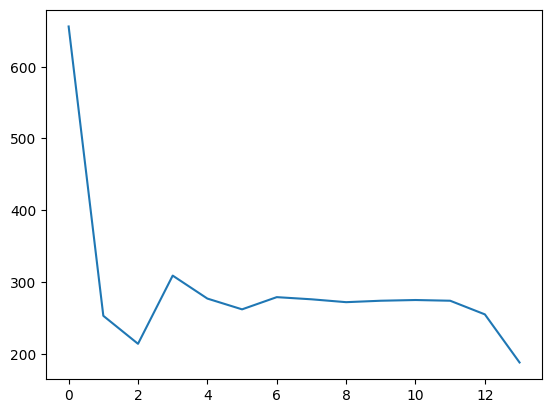

In [68]:
ipis, _ = model.simulate()
print(ipis)
print(ipis_ideal[1])
plt.plot(ipis)
np.corrcoef(ipis, ipis_ideal[1])

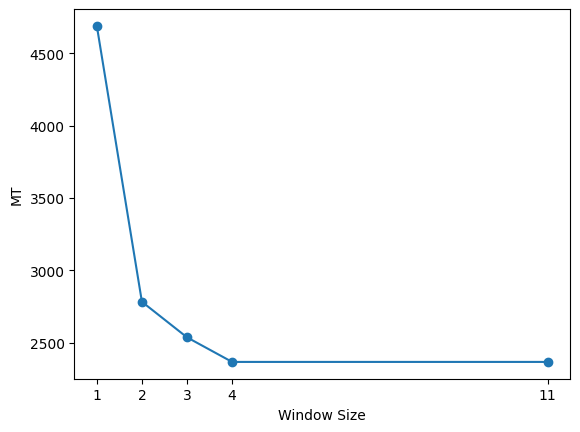

CPU times: user 3.28 s, sys: 61.7 ms, total: 3.34 s
Wall time: 3.31 s


In [149]:
%%time 
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 50
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = 0, 
    threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=4, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.show()


dict_values([6958.0, 4826.0, 4291.0, 4064.0, 4064.0])


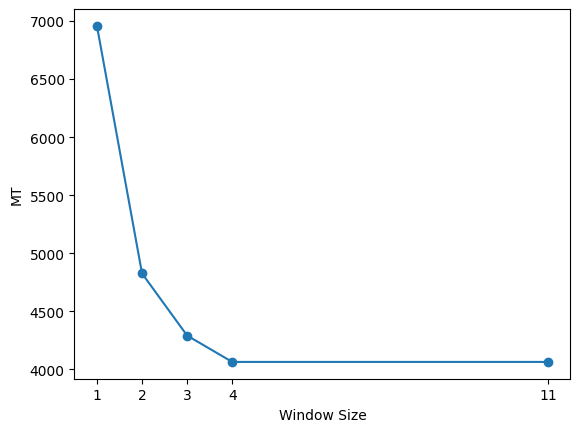

CPU times: user 3.75 s, sys: 76.2 ms, total: 3.83 s
Wall time: 3.78 s


In [69]:
%%time 
visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 50
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, seq_length=seq_length,
    threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

print(MT_mean.values())

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.show()


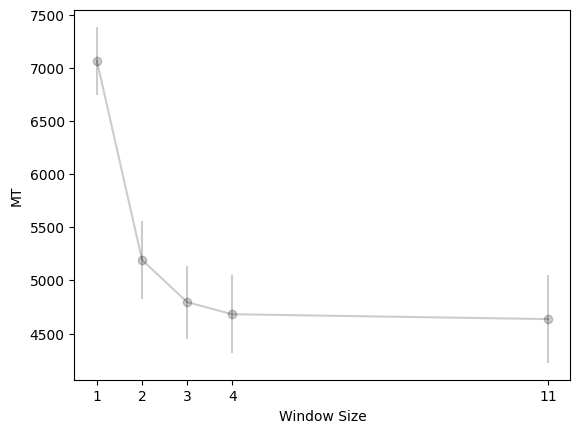

CPU times: user 7.6 s, sys: 147 ms, total: 7.75 s
Wall time: 7.75 s


In [70]:
%%time 
visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 100
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = diffusion, 
    threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, 
    planning_capacity=3, planning_param=param, seq_length = seq_length, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', color = 'black', alpha = 0.2)
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.show()


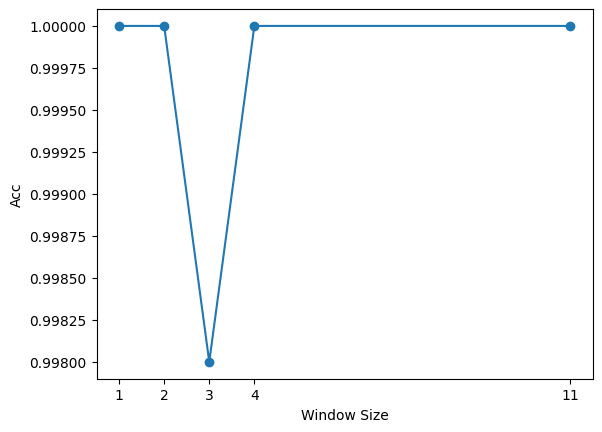

CPU times: user 1min 15s, sys: 1.68 s, total: 1min 16s
Wall time: 1min 17s


In [71]:
%%time 
visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 1000
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = diffusion, threshold = threshold , window_size=window, visual_delay=visual_delay, motor_delay = motor_delay
    , planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(check_evidence_to_seq(evidence, random_seq))


#Calculating mean and std for each window size
MT_mean = {window: np.sum(MT_vals) for window, MT_vals in MT.items()}
# MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

# plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.errorbar(MT_mean.keys(), np.array(list(MT_mean.values()))/num_sims, fmt='-o')

plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('Acc')
plt.show()


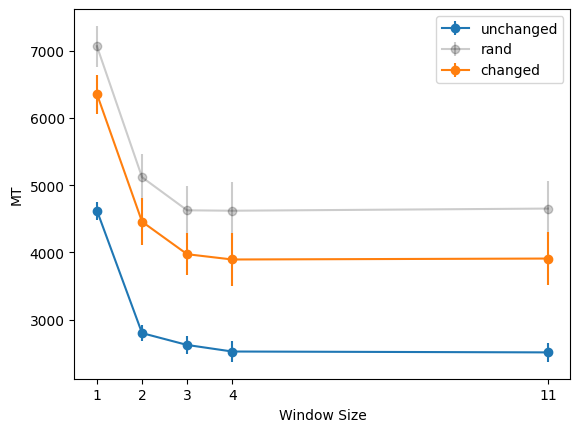

CPU times: user 1min 45s, sys: 1.98 s, total: 1min 47s
Wall time: 1min 49s


In [154]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

MT = {window: [] for window in window_sizes}
num_sims = 500
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, 
    window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=4, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, 
    visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=4, planning_param=param, seq_length = seq_length, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])


visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed, specific_seq, visual_drifts, memory_drifts, diffusion,
     threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=4, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])





plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.legend()
plt.show()


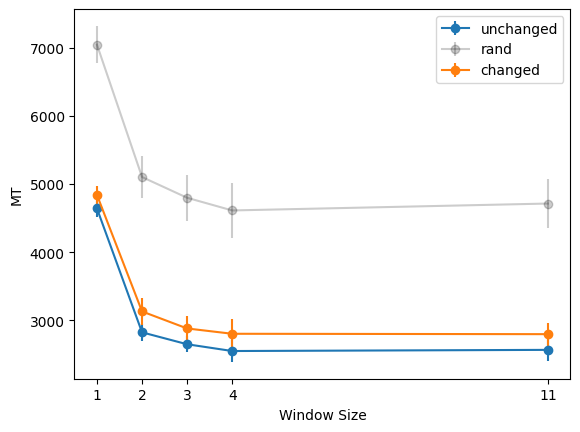

CPU times: user 11.9 s, sys: 282 ms, total: 12.1 s
Wall time: 12.2 s


In [131]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 50
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha , beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])



visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])





plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.legend()
plt.show()


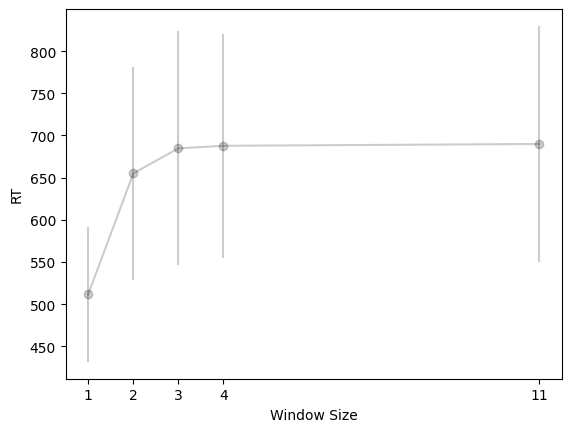

CPU times: user 38.8 s, sys: 752 ms, total: 39.5 s
Wall time: 39.7 s


In [28]:
%%time
RT = {window: [] for window in window_sizes}
num_sims = 500
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = diffusion, threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, seq_length = seq_length, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', color = 'black', alpha = 0.2)
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('RT')
plt.show()


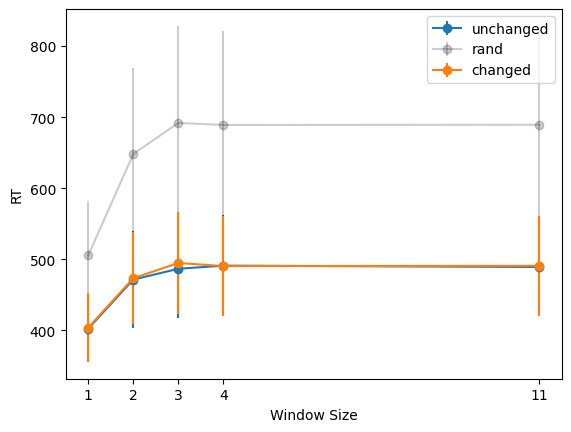

CPU times: user 1min 43s, sys: 1.66 s, total: 1min 45s
Wall time: 1min 45s


In [97]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

RT = {window: [] for window in window_sizes}
num_sims = 500
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
    window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])



visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
RT = {window: [] for window in window_sizes}
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = diffusion, threshold = threshold, window_size=window, 
    visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])



visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
RT = {window: [] for window in window_sizes}
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq_changed, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold,
     window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])






plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('RT')
plt.legend()
plt.show()


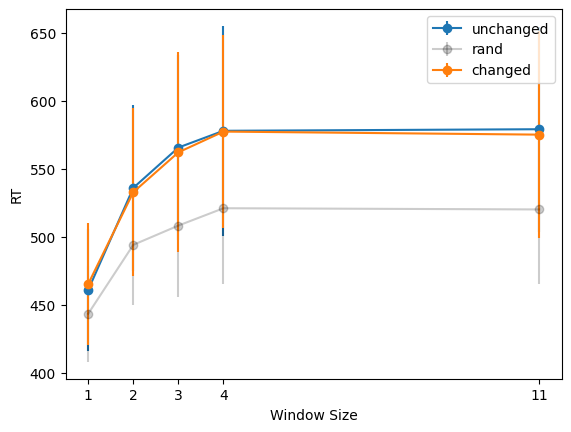

CPU times: user 1min 19s, sys: 1.23 s, total: 1min 20s
Wall time: 1min 21s


In [ ]:
%%time 
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

RT = {window: [] for window in window_sizes}
num_sims = 500
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, 
    window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])

RT = {window: [] for window in window_sizes}
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, 
    visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])


RT = {window: [] for window in window_sizes}
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq_changed, visual_drifts, memory_drifts, diffusion, threshold,
     window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])






plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('RT')
plt.legend()
plt.show()


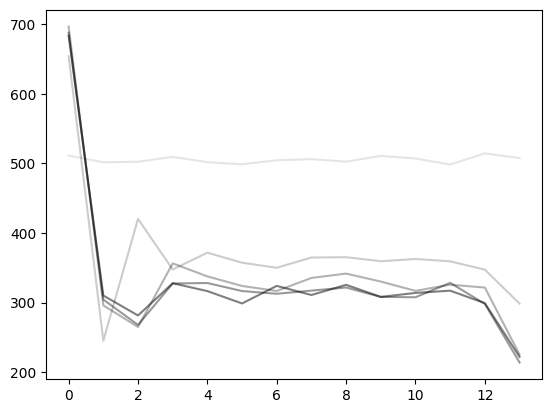

CPU times: user 37.7 s, sys: 746 ms, total: 38.4 s
Wall time: 38.6 s


In [76]:
%%time 
num_sims = 500


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = diffusion, threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length, dt= 1)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))


# plt.ylim([100,550])
# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


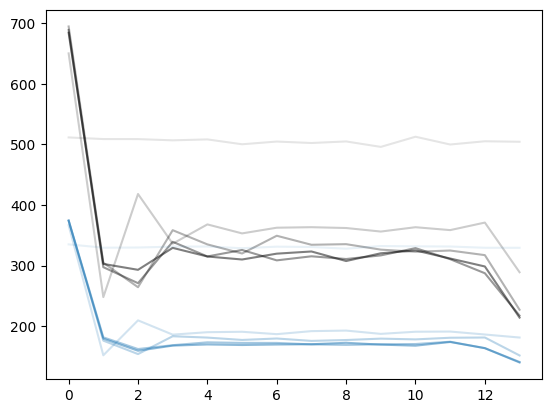

CPU times: user 1min 9s, sys: 1.53 s, total: 1min 10s
Wall time: 1min 11s


In [77]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}
num_sims = 500


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = diffusion, threshold = threshold, window_size=window, 
    visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))


visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, 
    memory_drifts, diffusion = diffusion, threshold = threshold, window_size=window, 
    visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C0', alpha = (idx+1)/(2 *len(window_sizes)))

# plt.legend()
# plt.ylim([100,700])
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


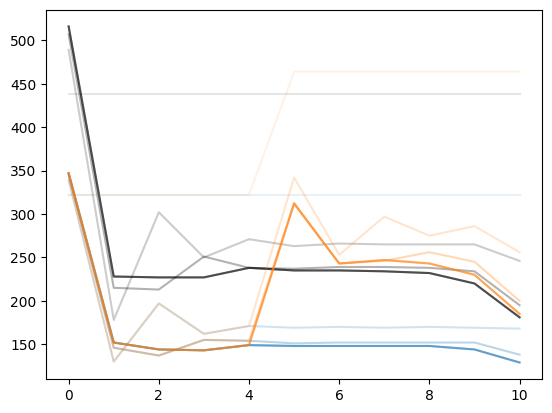

In [ ]:

num_sims = 50

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0
                                          , threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha , beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion = 0, threshold = threshold, window_size=window, 
                                          visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C0', alpha = (idx+1)/(2 *len(window_sizes)))




visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed, specific_seq, visual_drifts, memory_drifts, diffusion = 0, 
                                          threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha , beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C1', alpha = (idx+1)/(2 *len(window_sizes)))


# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


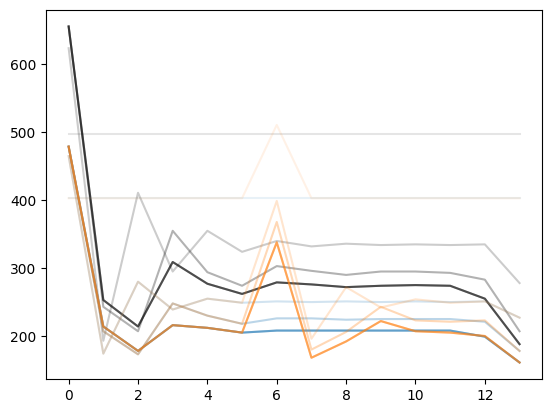

In [98]:

num_sims = 1

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion= 0, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = 0 , threshold= threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C0', alpha = (idx+1)/(2 *len(window_sizes)))




visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = 0, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C1', alpha = (idx+1)/(2 *len(window_sizes)))

# plt.ylim([100,550])
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 11: 0.99}


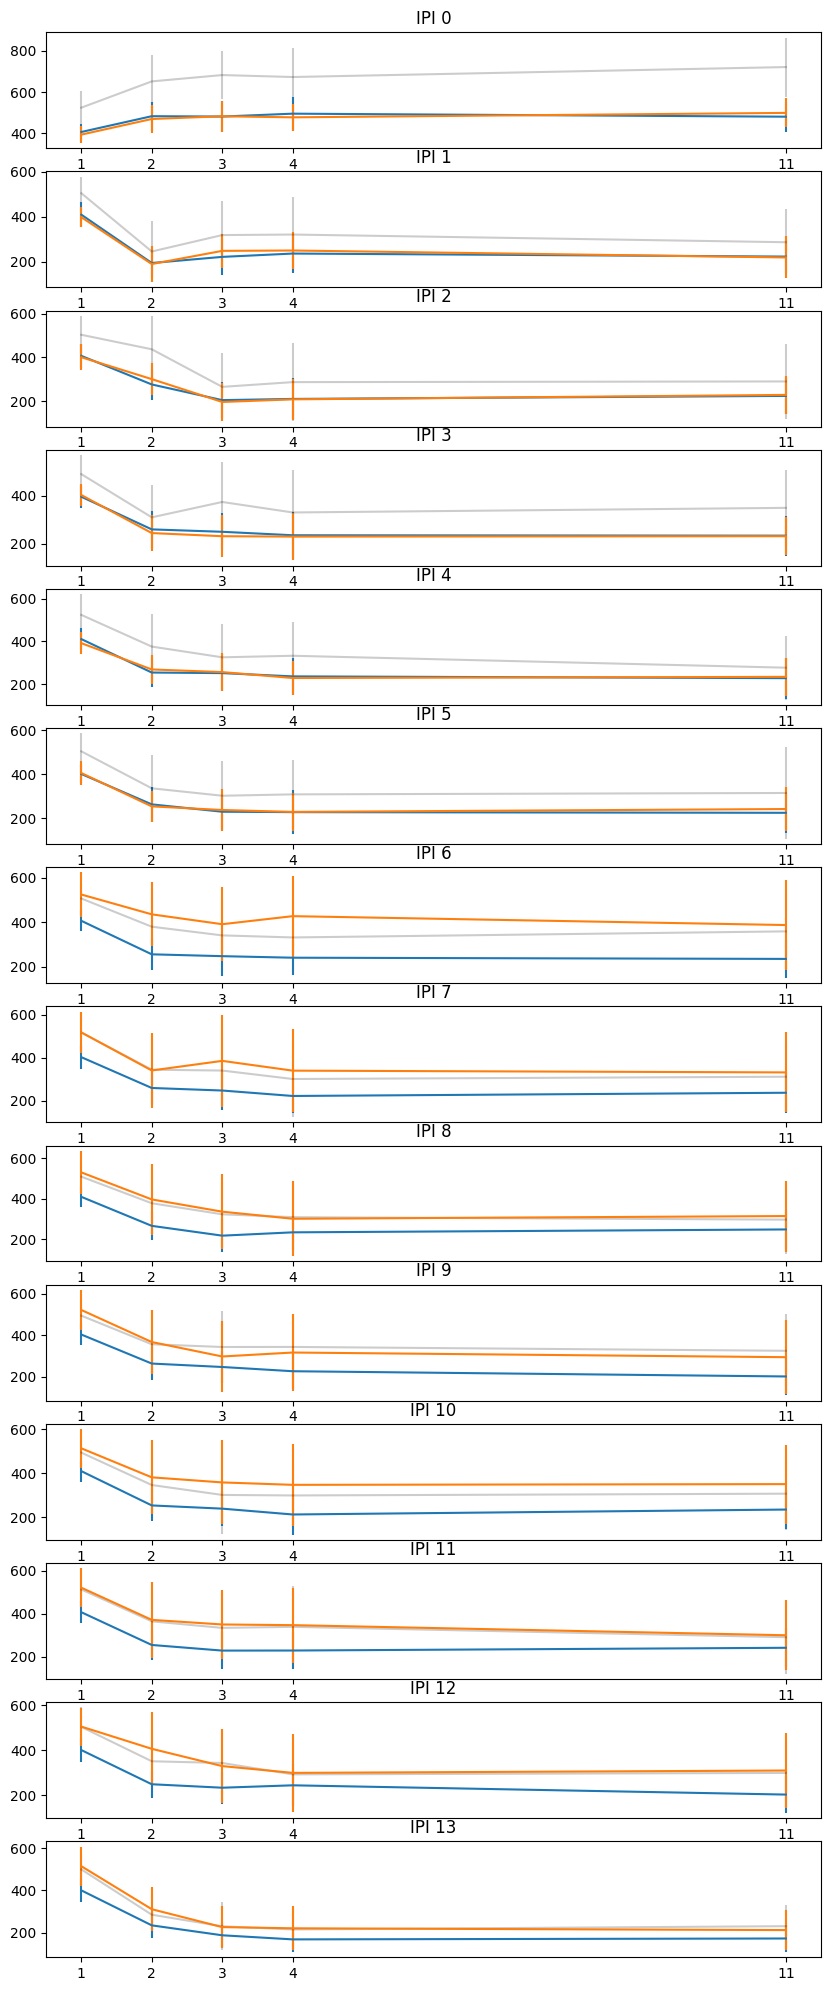

In [99]:
fig, axs = plt.subplots(seq_length, figsize = (10,25))
num_sims = 100


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
                                          diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay=motor_delay
                                          ,planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'black', alpha = 0.2)
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, 
                                          memory_drifts, diffusion, threshold, window_size=window, 
                                          visual_delay=visual_delay, motor_delay=motor_delay,
                                            planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C0')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
acc = {window: np.empty(num_sims) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed, specific_seq, visual_drifts, 
                                          memory_drifts, diffusion, threshold, window_size=window,
                                            visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param
                                            , alpha = alpha, beta = beta, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        acc[window][sim] = check_evidence_to_seq(evidence, specific_seq_changed)
        IPI[window][:, sim ] = IPIs

acc_mean = {window: acc_vals.mean() for window, acc_vals in acc.items()}

print(acc_mean)


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C1')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


unchanged  {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 11: 1.0}


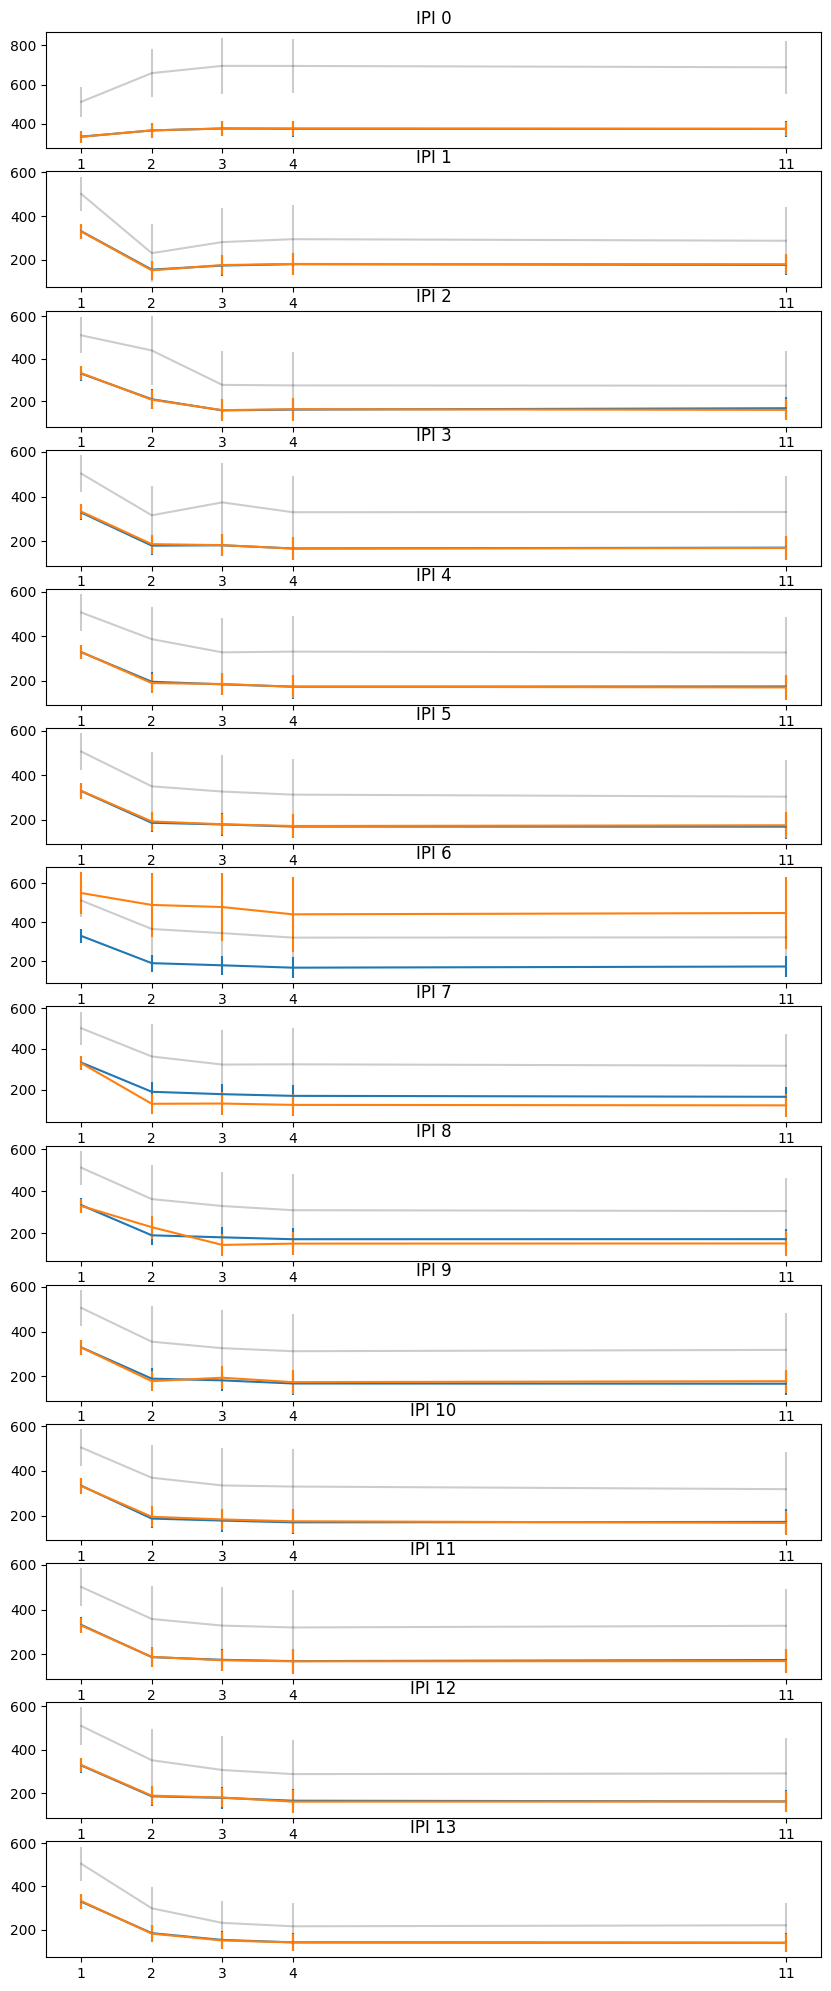

In [162]:
fig, axs = plt.subplots(seq_length, figsize = (10,25))
num_sims = 500


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion, 
                                          threshold, window_size=window, 
                                          visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
                                          planning_param=param, alpha = alpha, beta = beta, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'black', alpha = 0.2)
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
acc = {window: np.empty(num_sims) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, 
                                          memory_drifts, diffusion, threshold, 
                                          window_size=window, visual_delay=visual_delay, motor_delay=motor_delay,
                                            planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        acc[window][sim] = check_evidence_to_seq(evidence, specific_seq)
        IPI[window][:, sim ] = IPIs

acc_mean = {window: acc_vals.mean() for window, acc_vals in acc.items()}

print("unchanged ", acc_mean)
#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C0')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
acc = {window: np.empty(num_sims) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, 
                                          memory_drifts, diffusion , threshold, 
                                          window_size=window, visual_delay=visual_delay, motor_delay=motor_delay,
                                            planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length=seq_length)
    sim = 0
    while(sim < num_sims):
        IPIs, evidence = model.simulate()
        correct_trial = check_evidence_to_seq(evidence, specific_seq_changed_one_digit)
        if (check_evidence_to_seq(evidence, specific_seq_changed_one_digit)):
            IPI[window][:, sim ] = IPIs
            sim += 1
        # acc[window][sim] = check_evidence_to_seq(evidence, specific_seq_changed_one_digit)
        # if (check_evidence_to_seq(evidence, specific_seq_changed_one_digit)):
        #     IPI[window][:, sim ] = IPIs
        # IPI[window][:, sim ] = IPIs

# acc_mean = {window: acc_vals.mean() for window, acc_vals in acc.items()}

# print("changed: ", acc_mean)

#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C1')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


In [95]:
from pyswarm import pso
from scipy.optimize import fmin


visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

change_idx = 6

def loss(memory_drift_coef):
    num_sims = 200
    IPI_rand = np.empty(num_sims)
    IPI_changed = np.empty(num_sims)
    for window in [4]:
        visual_drifts = calc_visual_drifts(random_seq, seq_length)
        memory_drifts = calc_memory_drifts(specific_seq, seq_length)
        model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion, 
                                    threshold, window_size=window, 
                                    visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
                                    planning_param=param, alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
        
        for sim in range(num_sims):
            IPIs, evidence = model.simulate()
            IPI_rand[sim] = IPIs[change_idx]

        visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
        memory_drifts = calc_memory_drifts(specific_seq, seq_length)
                
        model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, 
            threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3,
                planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef=memory_drift_coef)
        sim = 0
        while(sim < num_sims):
            IPIs, evidence = model.simulate()
            correct_trial = check_evidence_to_seq(evidence, specific_seq_changed_one_digit)
            if (correct_trial):
                IPI_changed[sim ] = IPIs[change_idx]
                sim += 1


        return IPI_changed.mean() - IPI_rand.mean()

    

def optimize():

    # motor_param = 2
    lb = np.zeros(1) + 0.3
    ub = np.ones(1)
    params_opt, loss_opt = pso(loss, lb, ub, maxiter=10, swarmsize=100, debug=True)

    return params_opt, loss_opt


In [96]:
optimize()

No constraints given.
New best for swarm at iteration 1: [1.] 23.07499999999999
New best for swarm at iteration 1: [1.] 14.920000000000016
Stopping search: Swarm best position change less than 1e-08


(array([1.]), 14.920000000000016)

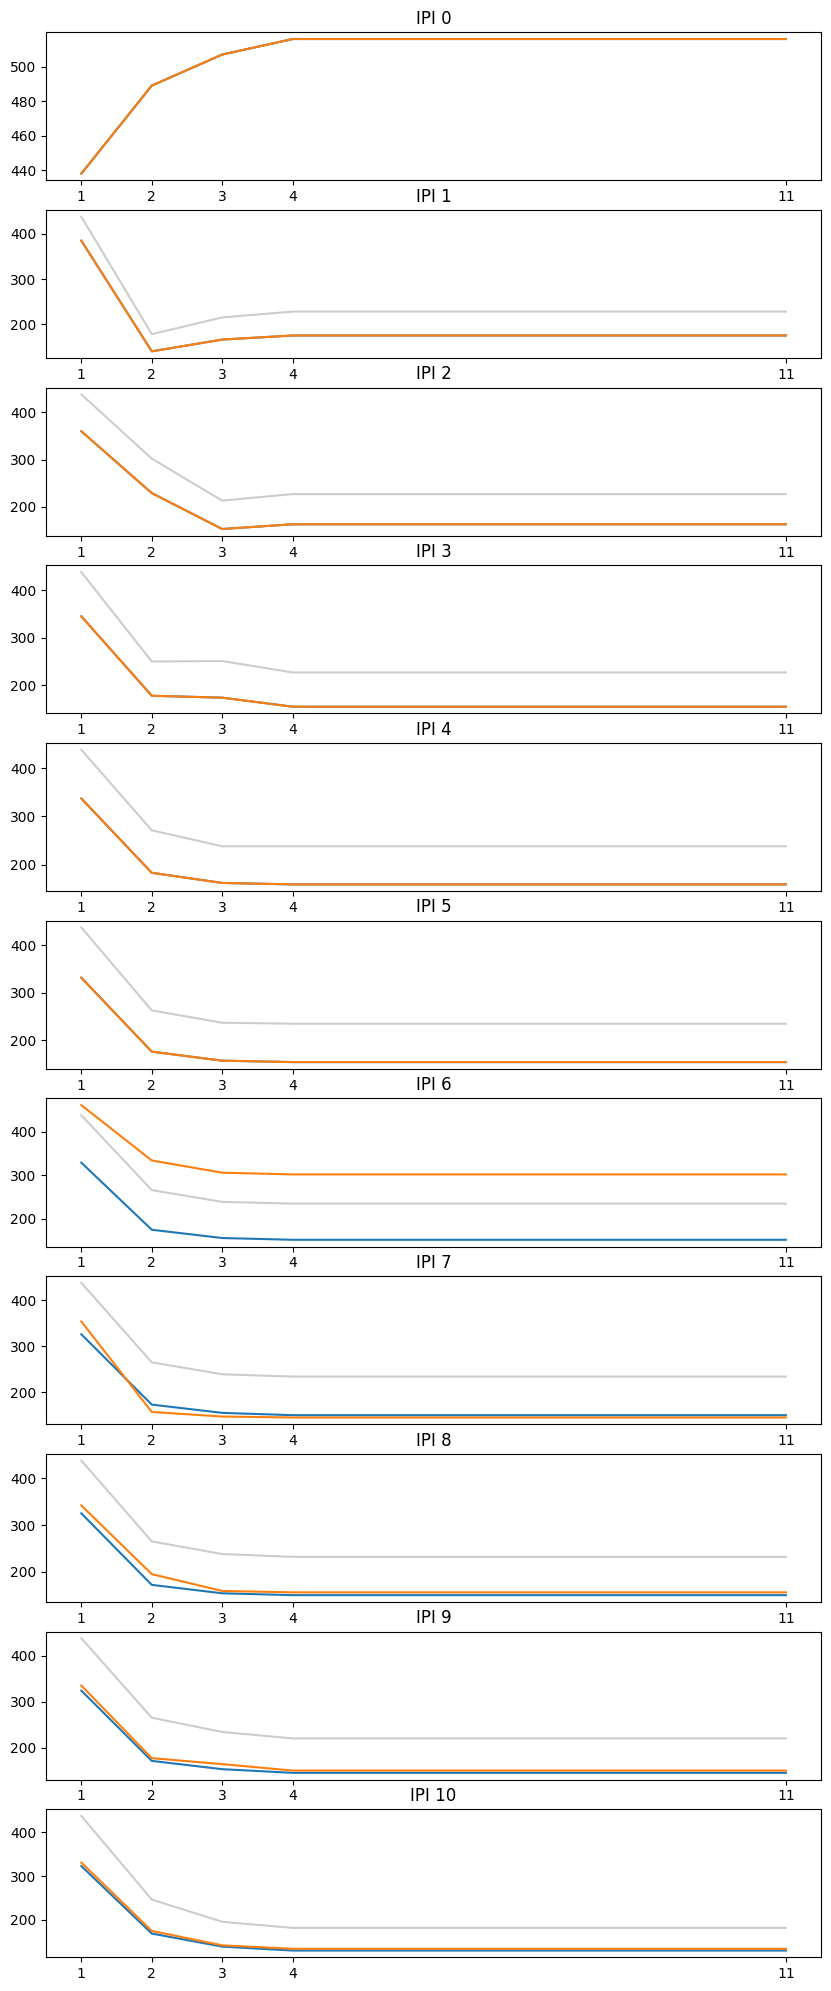

In [ ]:
fig, axs = plt.subplots(seq_length, figsize = (10,25))
num_sims = 1


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, 
                                          threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha , beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'black', alpha = 0.2)
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, 
                                          memory_drifts, diffusion = 0, threshold = threshold, 
                                          window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha , beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C0')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, 
                                          memory_drifts, diffusion = 0, threshold = threshold, 
                                          window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha , beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C1')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


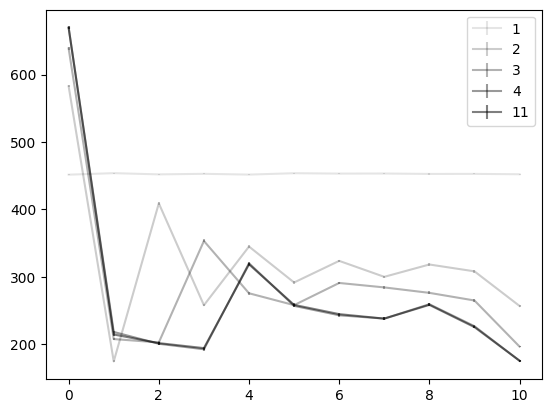

In [ ]:
num_sims = 10000
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window], label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    # plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}


plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


current memory:  0.7
current vision:  1
current memory:  0.7
current vision:  1
current memory:  0.7
current vision:  1
current memory:  0.7
current vision:  1
current memory:  0.7
current vision:  1
current memory:  0.7
current vision:  1
current memory:  0.7
current vision:  1
current memory:  0.7
current vision:  1
current memory:  0.7
current vision:  1
current memory:  0.7
current vision:  1
current memory:  0.7
current vision:  1
current memory:  0.7
current vision:  1
current memory:  0.7
current vision:  1
current memory:  0.7
current vision:  1


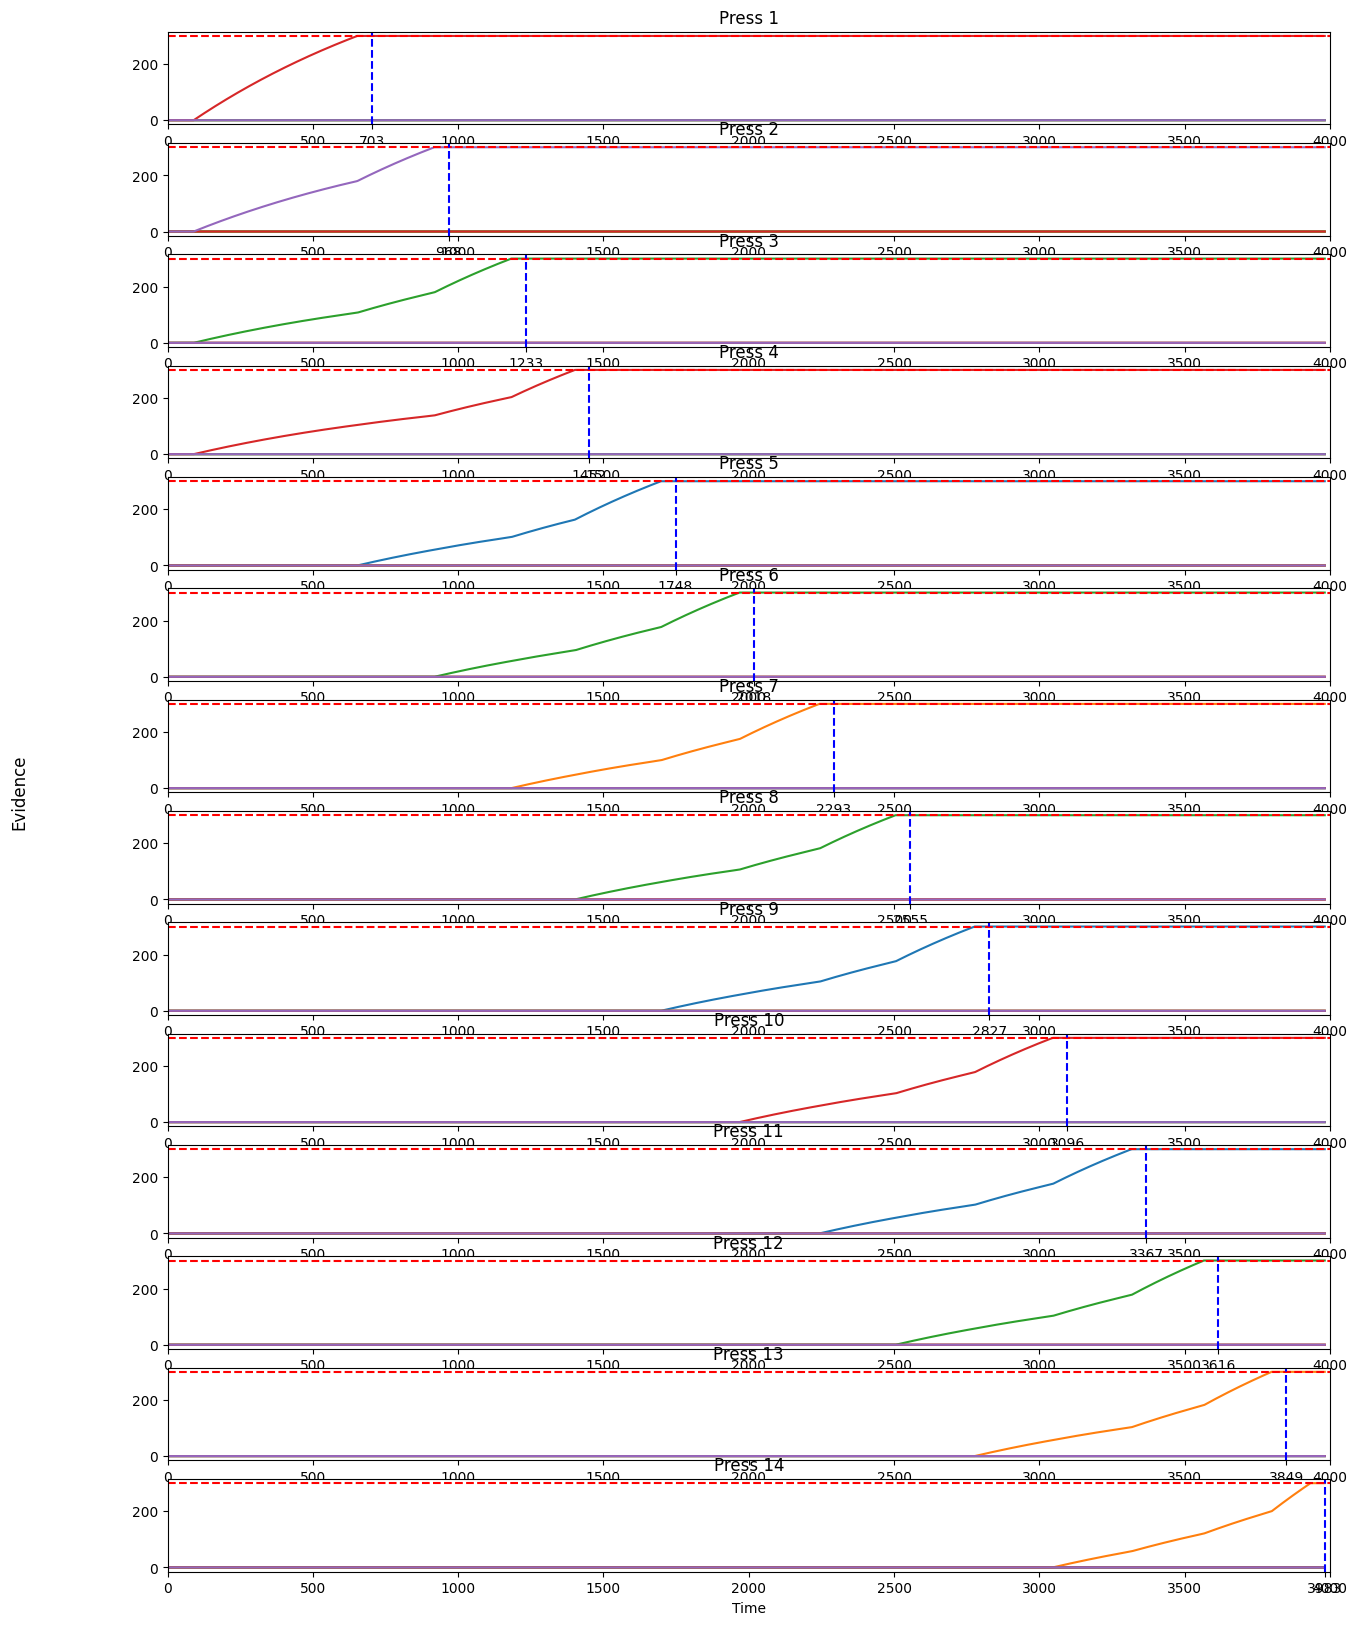

In [72]:
visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
                                      diffusion = 0, threshold = threshold, visual_delay=visual_delay, motor_delay= motor_delay,
                                      planning_capacity=4, planning_param=param, seq_length=seq_length, alpha = alpha, beta = beta, window_size=11)
model.plot_simulations()
# model.simulate()
# model.plot_IPIs()

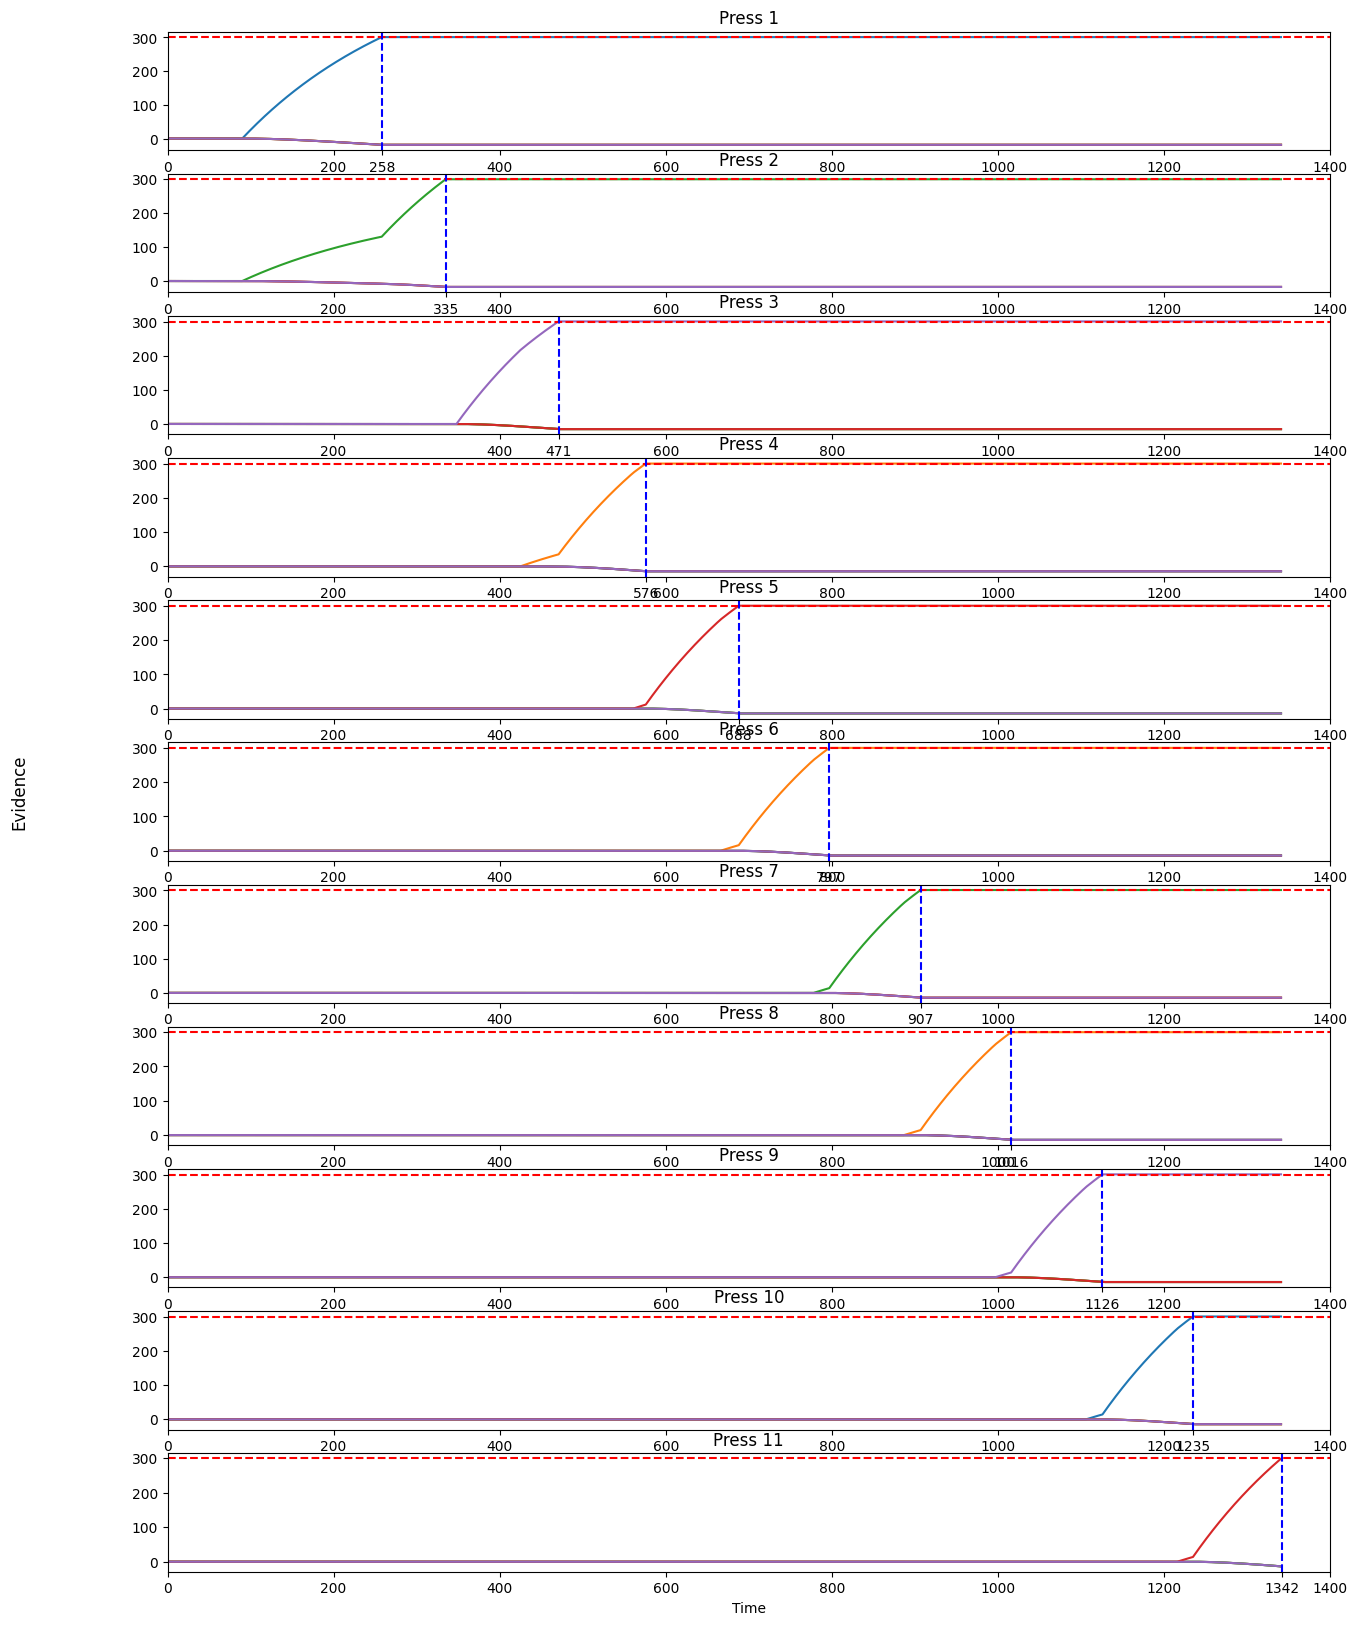

In [ ]:
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion = 0, threshold = threshold, visual_delay=90, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = 0.995, window_size=2)
model.plot_simulations()
# model.simulate()
# model.plot_IPIs()

In [ ]:
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

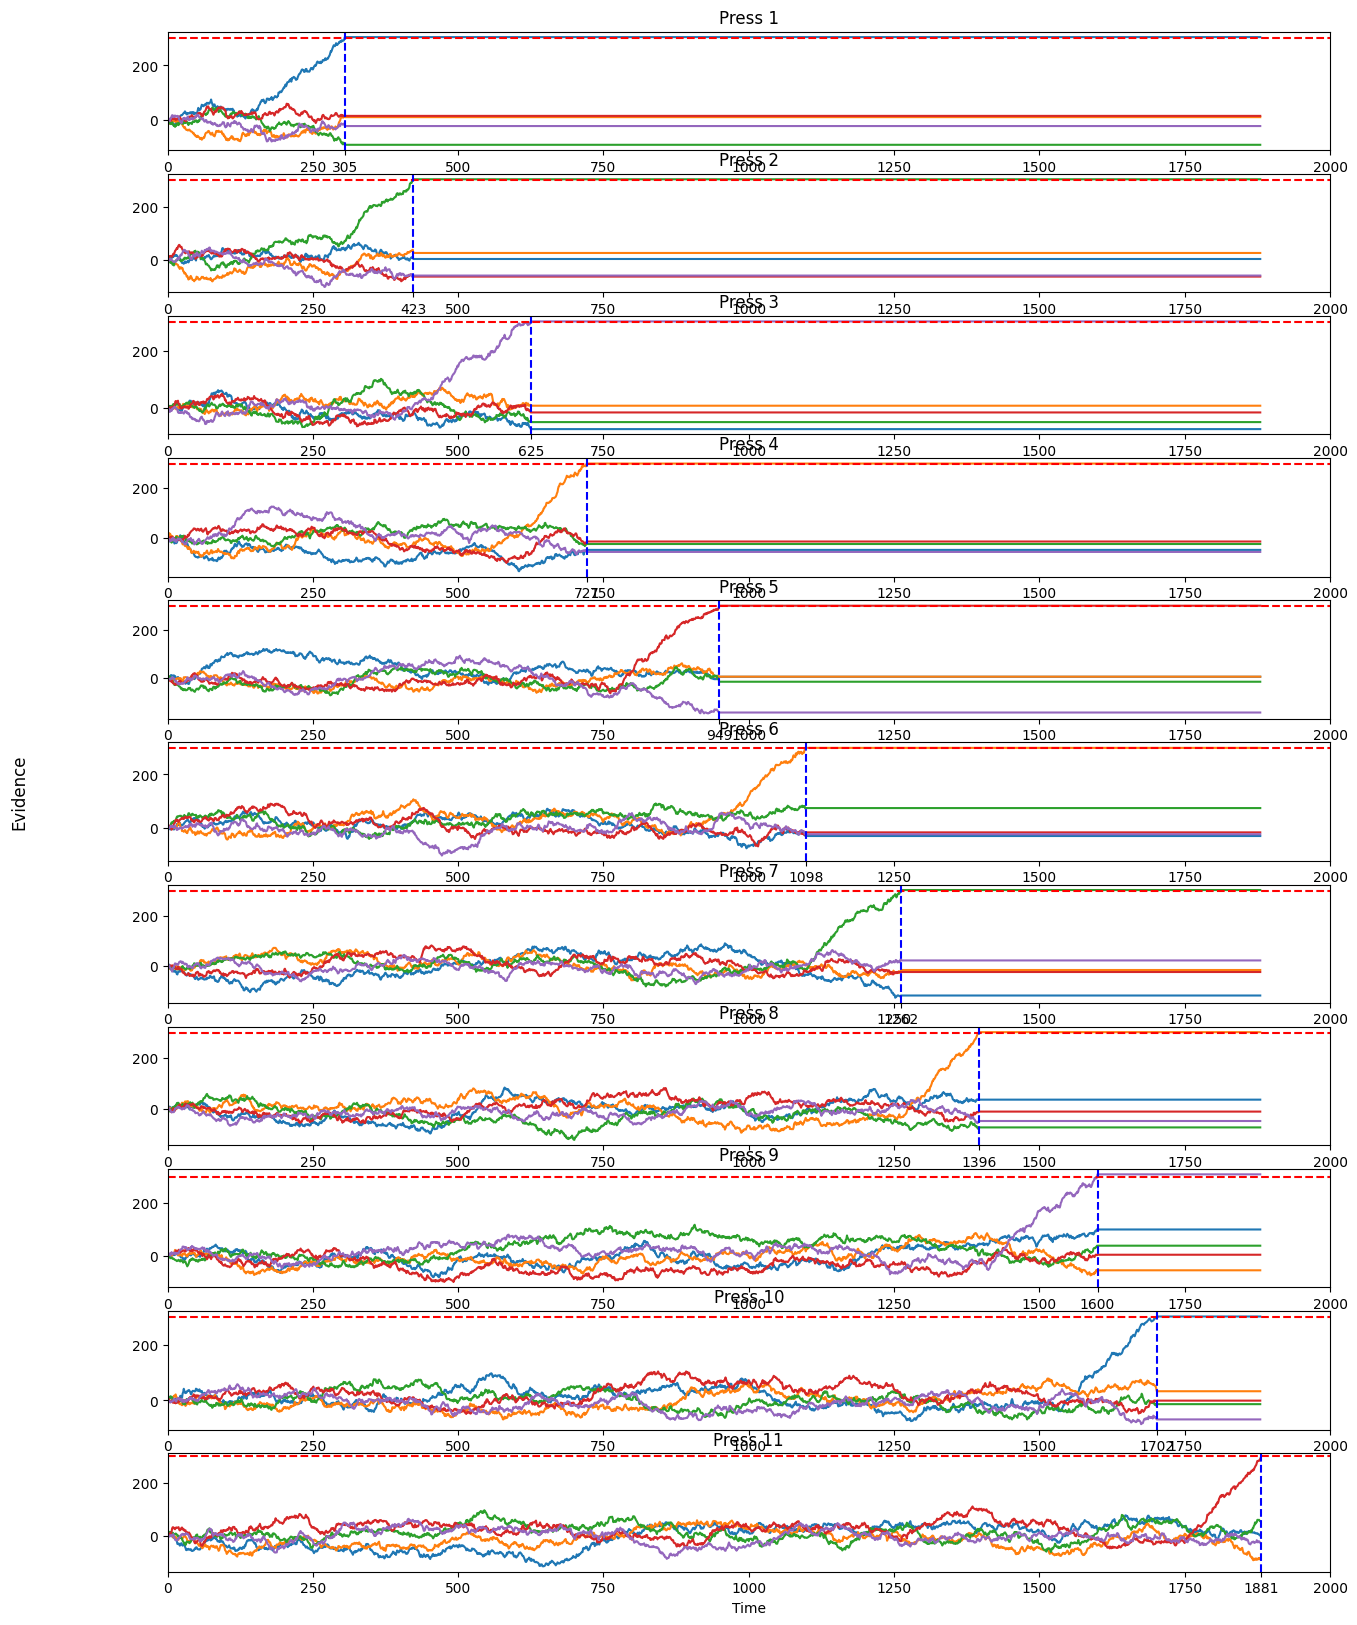

In [ ]:
model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=150, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = 0.995, window_size=2)
model.plot_simulations()
# model.simulate()
# model.plot_IPIs()

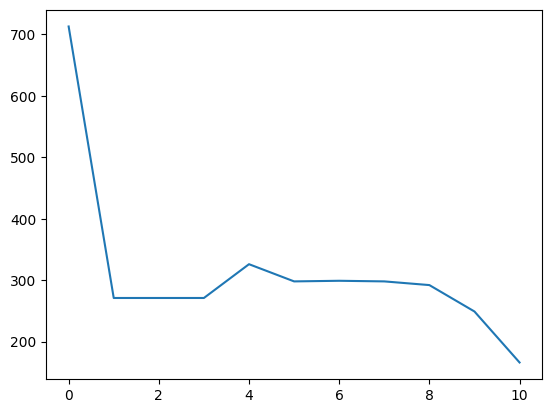

Timer unit: 1e-09 s

Total time: 0.122592 s
File: /var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_45128/1401399385.py
Function: simulate at line 30

Line #      Hits         Time  Per Hit   % Time  Line Contents
    30                                               def simulate(self):
    31                                                   """
    32                                                   Simulate the drift-diffusion processes until one reaches the threshold.
    33                                           
    34                                                   Returns:
    35                                                   decision_time (float): The time it took for the first process to reach the threshold.
    36                                                   winner (int): The index of the process that reached the threshold first.
    37                                                   """
    38         1       8000.0   8000.0      0.0          evidenc

In [ ]:

model = DriftDiffusionModel(drifts, diffusion = 0, threshold = threshold, visual_delay=150, window_size=4, planning_capacity=4, planning_param=2)
# model.plot_simulations()
%lprun -f model.simulate model.simulate()
model.plot_IPIs()

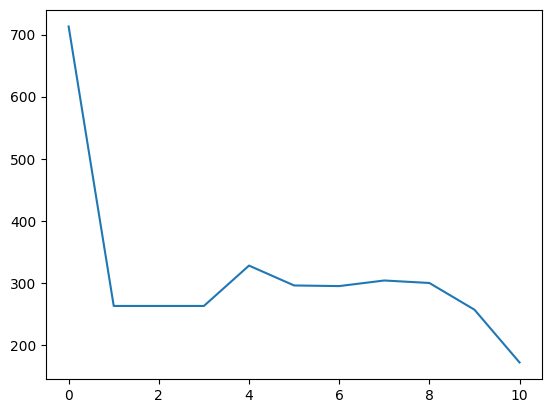

Timer unit: 1e-09 s

Total time: 0.003654 s
File: /var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_45128/2668952069.py
Function: simulate at line 31

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                               def simulate(self):
    32         1    3653000.0    4e+06    100.0          press_times = simulate_ddm(self.drifts, self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, self.window_size, self.planning_capacity, self.planning_param, self.planning_strategy, self.visual_delay)
    33         1       1000.0   1000.0      0.0          self.press_times = press_times

In [ ]:

model = DriftDiffusionModel_Optimzied(drifts, diffusion = 0, threshold = threshold, visual_delay=150, window_size=4, planning_capacity=4, planning_param=2, planning_strategy=0)
# model.plot_simulations()
%lprun -f model.simulate model.simulate()
model.plot_IPIs()

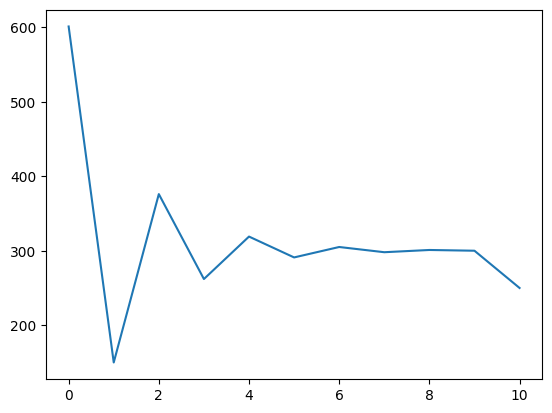

Timer unit: 1e-09 s

Total time: 0.001964 s
File: /var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_45221/2282306544.py
Function: simulate at line 31

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                               def simulate(self):
    32         1    1955000.0    2e+06     99.5          press_times = simulate_ddm(self.drifts, self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, self.window_size, self.planning_capacity, self.planning_param, self.planning_strategy, self.visual_delay)
    33         1       1000.0   1000.0      0.1          self.press_times = press_times
    34         1       8000.0   8000.0      0.4          return calculate_IPI_from_press_time(self.press_times)

In [ ]:

model = DriftDiffusionModel_Optimzied(drifts, diffusion = 0, threshold = threshold, visual_delay=150, window_size=2, planning_capacity=4, planning_param=2, planning_strategy=0)
# model.plot_simulations()
%lprun -f model.simulate model.simulate()
model.plot_IPIs()

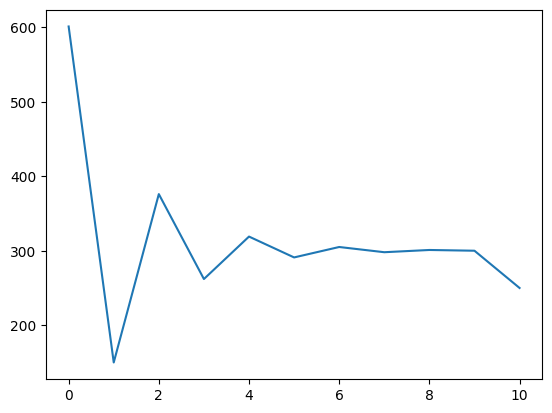

Timer unit: 1e-09 s

Total time: 0.06892 s
File: /var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_45221/1401399385.py
Function: simulate at line 30

Line #      Hits         Time  Per Hit   % Time  Line Contents
    30                                               def simulate(self):
    31                                                   """
    32                                                   Simulate the drift-diffusion processes until one reaches the threshold.
    33                                           
    34                                                   Returns:
    35                                                   decision_time (float): The time it took for the first process to reach the threshold.
    36                                                   winner (int): The index of the process that reached the threshold first.
    37                                                   """
    38         1      13000.0  13000.0      0.0          evidence

In [ ]:

model = DriftDiffusionModel(drifts, diffusion = 0, threshold = threshold, visual_delay=150, window_size=2, planning_capacity=4, planning_param=2)
# model.plot_simulations()
%lprun -f model.simulate model.simulate()
model.plot_IPIs()